# Decision tree vs Bagging vs Boosting on Fish dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import kagglehub
from kagglehub import KaggleDatasetAdapter
import time
import joblib
import os

/opt/anaconda3/envs/ml_basic/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import dataset

In [11]:
# Loading dataset from online source (kaggle). Source:https://www.kaggle.com/datasets/markdaniellampa/fish-dataset
file_path = "Fish.csv"
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,
  "vipullrathod/fish-market",
  file_path,)
df.info()
df.describe()

/var/folders/s5/8l7hsvns557325k6kcpgrp1h0000gn/T/ipykernel_14610/229192478.py:3: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


If you don't want to load it from online, you can download the dataset from above source or from this repository, but if you would like to share it, please acknowledge the online source (kaggle)

In [3]:
# Load dataset from local file
# df = pd.read_csv(file_path)
# df.info()

In [4]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


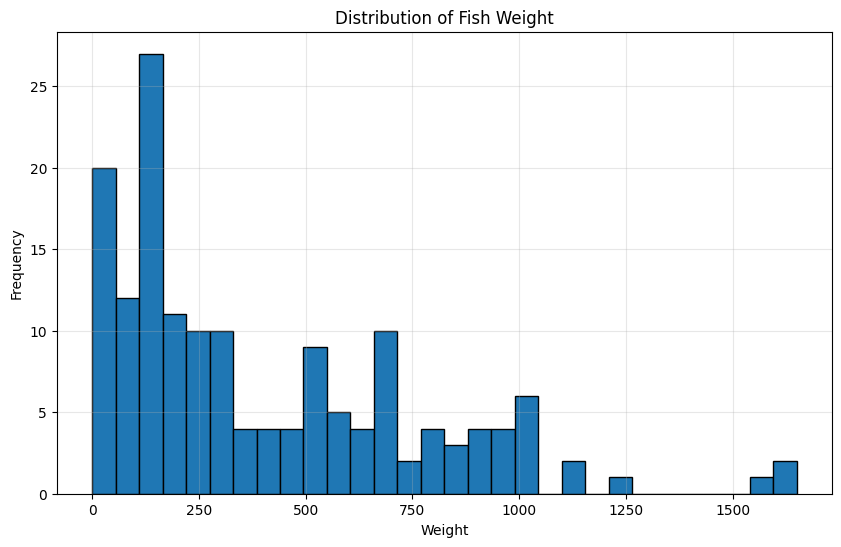

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(df['Weight'], bins=30, edgecolor='black')
plt.title('Distribution of Fish Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

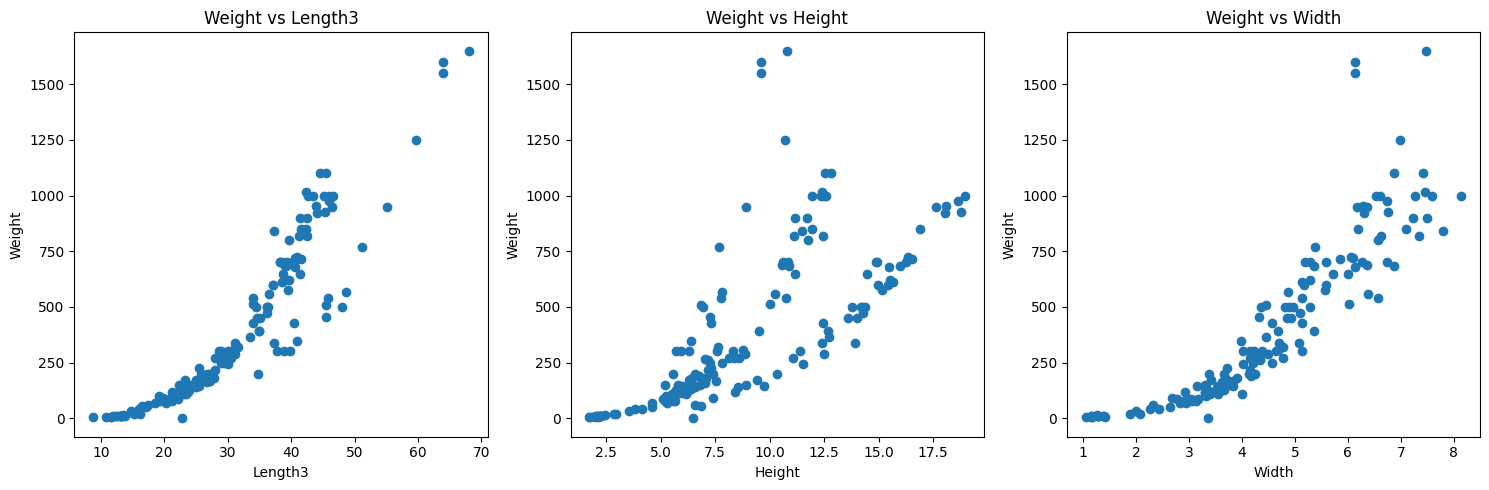

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Weight vs Length3
axes[0].scatter(df['Length3'], df['Weight'])
axes[0].set_xlabel('Length3')
axes[0].set_ylabel('Weight')
axes[0].set_title('Weight vs Length3')

# Plot Weight vs Height
axes[1].scatter(df['Height'], df['Weight'])
axes[1].set_xlabel('Height')
axes[1].set_ylabel('Weight')
axes[1].set_title('Weight vs Height')

# Plot Weight vs Width
axes[2].scatter(df['Width'], df['Weight'])
axes[2].set_xlabel('Width')
axes[2].set_ylabel('Weight')
axes[2].set_title('Weight vs Width')

plt.tight_layout()

The above feature comparison exhibits quadratic (approximately) behaviour

In [7]:
X = df[["Length1", "Length2", "Length3", "Height", "Width"]]
y = df["Weight"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

## Training and Inference

In [8]:
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

In [9]:
# Define models
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Bagging Tree': BaggingRegressor(n_estimators=100, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}


results = []
dataset_prefix = 'fish'

# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        'Model': name,
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Training Time': training_time
    }
    results.append(metrics)
    # Save the models
    model_filename = os.path.join(models_dir, f"{dataset_prefix}_{name.lower().replace(' ', '_')}.pkl")
    joblib.dump(model, model_filename)

# Display results
results_df = pd.DataFrame(results)
print(results_df.round(3))


               Model  Train R²  Test R²  Train RMSE  Test RMSE  Train MAE  \
0      Decision Tree     1.000    0.939       3.137     93.087      0.394   
1       Bagging Tree     0.997    0.970      20.388     64.813     13.538   
2      Random Forest     0.997    0.968      20.654     67.601     13.691   
3           AdaBoost     0.985    0.942      42.700     90.666     33.364   
4  Gradient Boosting     0.999    0.976       9.867     58.214      7.320   

   Test MAE  Training Time  
0    52.369          0.002  
1    42.902          0.052  
2    44.730          0.035  
3    67.626          0.036  
4    37.884          0.020  


In [10]:
os.makedirs('output', exist_ok=True)
# Save the results to a CSV file
results_df.to_csv(os.path.join('output', f"{dataset_prefix}_trees_results.csv"), index=False)